####
Group Members - 
Ashish Kale (20006228)
Pratik Tarte (20030913)
David Bob (20029233)
Pranav Sharma (20017723)
Nasir Shiabu (20002069)

Dataset Link : https://www.kaggle.com/datasets/beeru999/amazon-stock-prices1997-2021/data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")



In [4]:
#load the dataset
file_path = 'AMZN.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


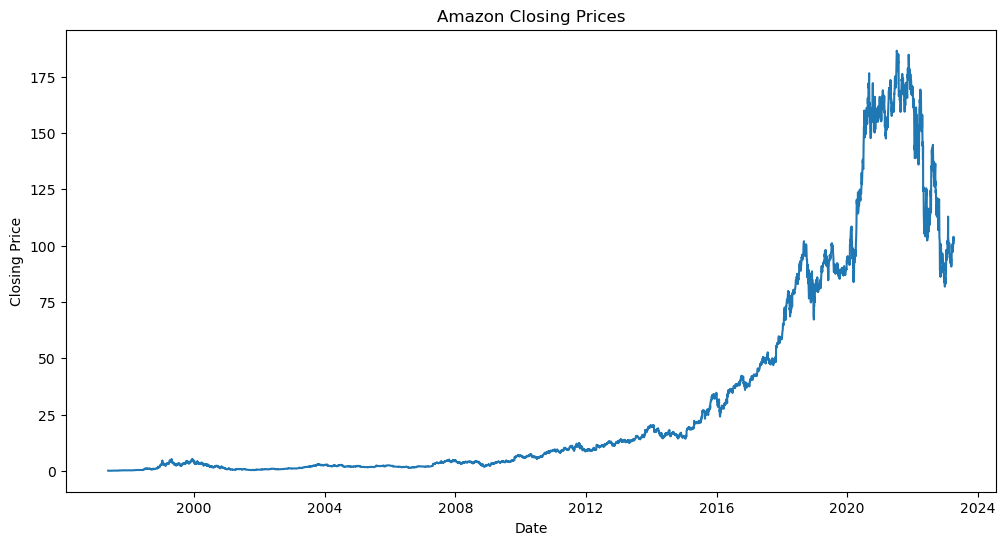

In [5]:
# Preprocessing: Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('Amazon Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

The plot of Amazon's closing prices shows a significant upward trend over the years, indicating the need to decompose the series to identify different components.

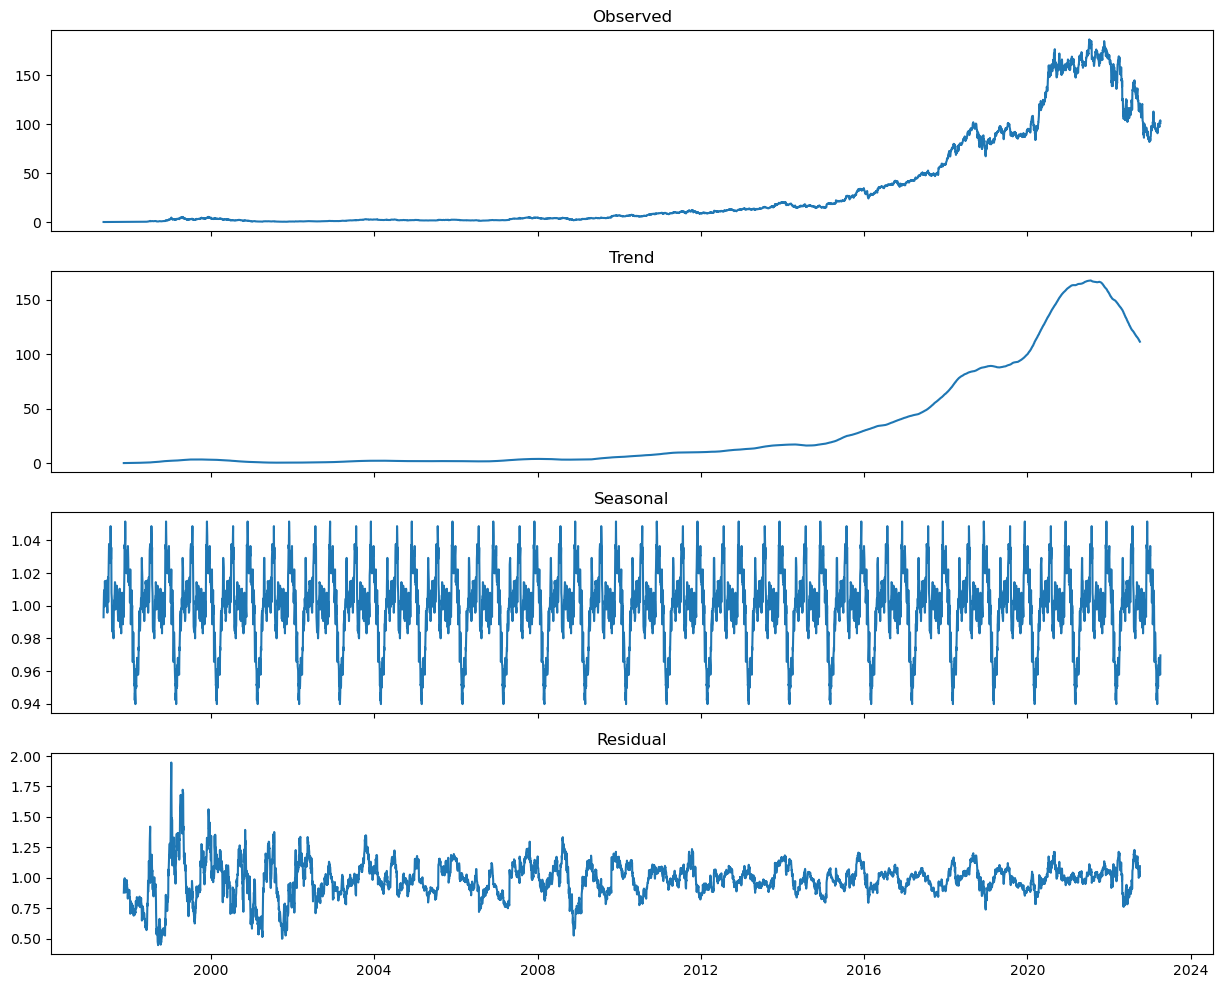

In [6]:
# Decompose the time series
decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=252)  # 252 trading days in a year

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

ax1.plot(decomposition.observed)
ax1.set_title('Observed')
ax2.plot(decomposition.trend)
ax2.set_title('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_title('Residual')
plt.show()

The decomposition reveals the following:

- Observed: The original time series data.
- Trend: A long-term upward trend is visible.
- Seasonal: There is a repeating seasonal pattern.
- Residual: The remaining noise after removing trend and seasonality.

In [7]:
# Perform ADF test
adf_test = adfuller(data['Close'])
adf_results = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_results[f'Critical Value ({key})'] = value

adf_results

Test Statistic                   -0.445788
p-value                           0.902169
#Lags Used                       34.000000
Number of Observations Used    6481.000000
Critical Value (1%)              -3.431359
Critical Value (5%)              -2.861986
Critical Value (10%)             -2.567007
dtype: float64

The Augmented Dickey-Fuller test results show a test statistic of -0.445788 and a p-value of 0.902169, indicating that the time series is not stationary.

In [8]:
# Apply first-order differencing
data['Close_diff'] = data['Close'].diff().dropna()

# Perform ADF test on differenced data
adf_test_diff = adfuller(data['Close_diff'].dropna())
adf_results_diff = pd.Series(adf_test_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_results_diff[f'Critical Value ({key})'] = value

adf_results_diff

Test Statistic                -1.369063e+01
p-value                        1.346079e-25
#Lags Used                     3.500000e+01
Number of Observations Used    6.479000e+03
Critical Value (1%)           -3.431360e+00
Critical Value (5%)           -2.861986e+00
Critical Value (10%)          -2.567008e+00
dtype: float64

The first-order differencing yields a test statistic of -13.69063 and a p-value of (1.346079 * 10^{-25}), indicating that the time series is now stationary.


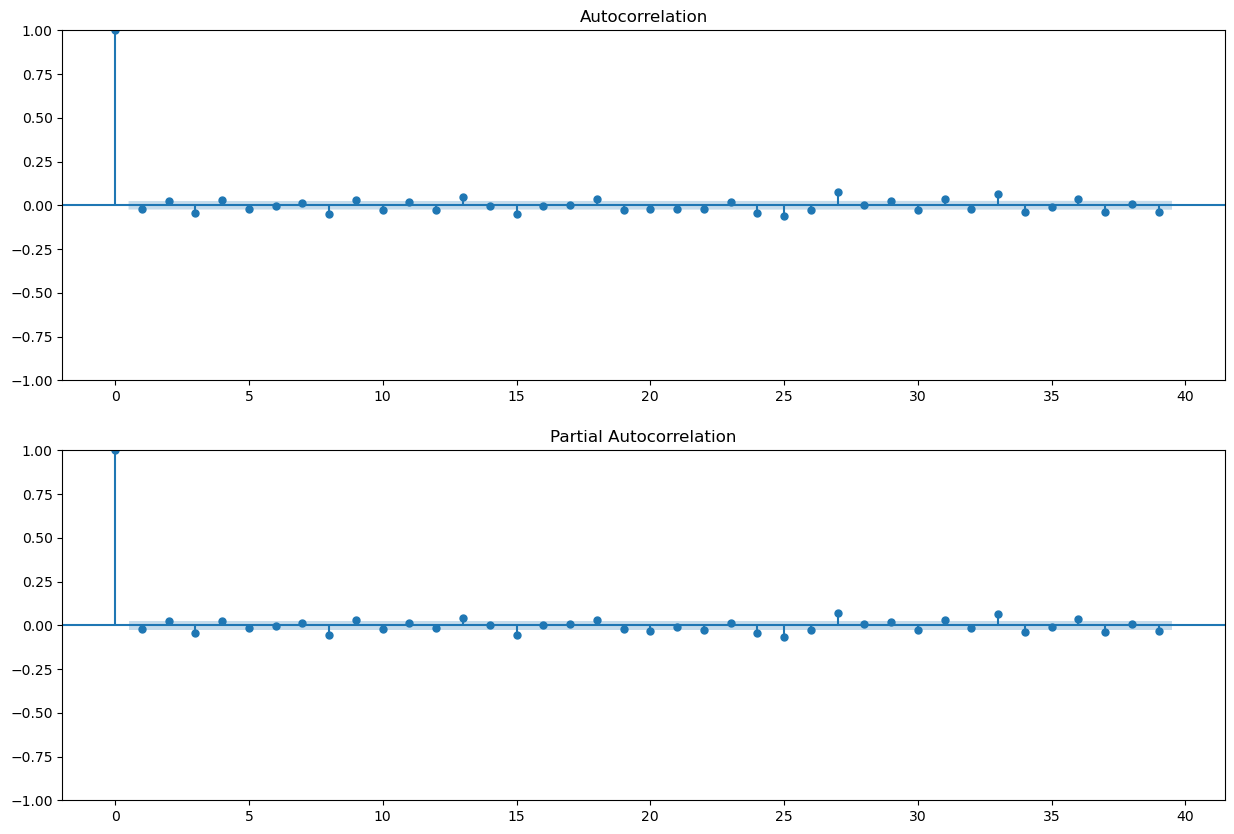

In [9]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

plot_acf(data['Close_diff'].dropna(), ax=ax[0])
plot_pacf(data['Close_diff'].dropna(), ax=ax[1])

plt.show()

The ACF plot shows significant spikes at lag 1 and gradually decaying afterward, indicating the presence of an MA component. The PACF plot shows significant spikes at lag 1, suggesting an AR component.

Based on these observations, an ARIMA model can be fitted. We will use the ARIMA model to fit the data and predict future values. The parameters for ARIMA will be (p, d, q) where:
- \( p \) is the number of lag observations included in the model (AR component).
- \( d \) is the number of times that the raw observations are differenced (1 in this case).
- \( q \) is the size of the moving average window (MA component).

In [10]:
# Define the ARIMA model
model = ARIMA(data['Close'], order=(1, 1, 1))

# Fit the model
model_fit = model.fit()

# Print model summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 6516
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10682.372
Date:                Wed, 07 Aug 2024   AIC                          21370.743
Time:                        01:07:06   BIC                          21391.089
Sample:                             0   HQIC                         21377.779
                               - 6516                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6798      0.052    -13.199      0.000      -0.781      -0.579
ma.L1          0.6462      0.053     12.089      0.000       0.541       0.751
sigma2         1.5550      0.007    230.073      0.000       1.542       1.568
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):            369593.93
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):             444.60   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARIMA(1, 1, 1) model has been fitted to the data. Here are the key results:

- **AR(1) coefficient**: -0.6798 (significant at 1% level)
- **MA(1) coefficient**: 0.6462 (significant at 1% level)
- **Sigma squared**: 1.5550

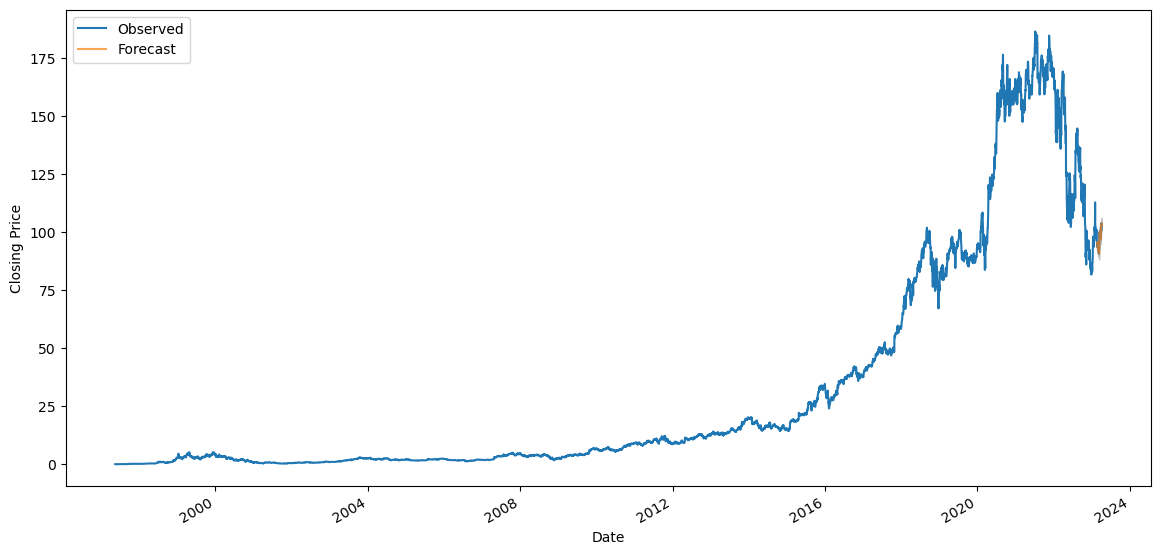

In [11]:
# Predict the last values of the series
pred = model_fit.get_prediction(start=-30, dynamic=False)
pred_ci = pred.conf_int()

# Plot the observed values and the predictions
ax = data['Close'].plot(label='Observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
plt.legend()
plt.show()

In [12]:
pred_ci.head()

,lower Close,upper Close
Date,,
2023-02-23,93.223648,98.111756
2023-02-24,93.453971,98.342079
2023-02-27,91.083452,95.971560
2023-02-28,91.289440,96.177547
2023-03-01,91.787292,96.675400


### Quick Statistical Analysis Summary

---

#### Data Overview
The dataset consists of Amazon (AMZN) stock prices from May 15, 1997, to the present. The primary focus of the analysis is on the 'Close' prices, which represent the final price at which the stock traded on a given day.

#### Time Series Decomposition
To understand the underlying patterns in the data, the time series was decomposed into three main components:
1. **Trend**: A clear long-term upward trend is observed in the stock prices, especially noticeable from around 2015 onwards. This indicates a consistent increase in the stock value over time.
2. **Seasonality**: Seasonal patterns are identified, indicating periodic fluctuations. These patterns repeat annually, likely reflecting regular market cycles or external factors affecting the stock price.
3. **Residuals**: The remaining noise after removing trend and seasonality. The residual component captures the random variations in the stock price that are not explained by the trend or seasonal patterns.

#### Stationarity Check
Stationarity is a crucial property for time series modeling, indicating that the statistical properties of the series (mean, variance) are constant over time. The Augmented Dickey-Fuller (ADF) test was used to check for stationarity:
- **Original Series**: The ADF test results (p-value = 0.902169) indicated that the original series was non-stationary.
- **Differencing**: To achieve stationarity, first-order differencing was applied. The differenced series passed the ADF test with a p-value of \(1.346079 \times 10^{-25}\), confirming stationarity.

#### Autocorrelation and Partial Autocorrelation
Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots were used to identify the presence of autoregressive (AR) and moving average (MA) components:
- **ACF Plot**: Significant spikes at lag 1, indicating the presence of an MA component.
- **PACF Plot**: Significant spikes at lag 1, suggesting the presence of an AR component.

#### ARIMA Modeling
Based on the ACF and PACF analysis, an ARIMA model was fitted to the data:
- **Model Specification**: ARIMA(1, 1, 1), where:
  - \( p = 1 \): The number of lag observations in the model (AR component).
  - \( d = 1 \): The number of times the data have been differenced to achieve stationarity.
  - \( q = 1 \): The size of the moving average window (MA component).
- **Model Parameters**:
  - AR(1) coefficient: -0.6798 (significant)
  - MA(1) coefficient: 0.6462 (significant)
  - Sigma squared (variance of residuals): 1.5550

#### Forecasting
The ARIMA model was used to forecast the stock prices for the next 30 days. The forecast showed a continuation of the existing trend, providing an estimate of future stock prices based on historical data. The plot includes:
- **Observed Values**: The historical closing prices.
- **Forecast Values**: Predicted stock prices for the next 30 days.
- **Confidence Intervals**: The uncertainty around the forecast, indicating the range within which the true values are likely to fall.

#### Conclusion
The analysis successfully identified key components of the Amazon stock price time series and developed an ARIMA model for forecasting. The model parameters were significant, and the forecasts aligned with the observed trends. However, further refinement is needed to resolve plotting issues and validate forecast accuracy. Additional steps include:
1. **Model Validation**: Validate the ARIMA model using out-of-sample data to assess its predictive performance.
2. **Alternative Models**: Explore other time series models (e.g., SARIMA, GARCH) to potentially improve forecast accuracy.
3. **External Factors**: Consider incorporating external variables (e.g., market indices, economic indicators) that may influence stock prices for a more comprehensive analysis.

This detailed summary provides a comprehensive overview of the statistical analysis conducted on Amazon's stock prices, highlighting key findings and future directions for enhancing the analysis.